In [ ]:
# Spatial frequency coordinates for the aperture
νx = sp.fft.fftshift(sp.fft.fftfreq(νx_num, 1 / (νx_num * (νpx[0, 1] - νpx[0, 0]))))
νy = sp.fft.fftshift(sp.fft.fftfreq(νy_num, 1 / (νy_num * (νpy[1, 0] - νpy[0, 0]))))

ν_xx, ν_yy = np.meshgrid(
    νx, νy,
    indexing='xy'
)

In [ ]:
# Axial location
z0 = 0.0  # Axial position of the focal plane

# Scatterers' locations
zs = np.array([0., 100., 200., -100., -200.], dtype=np.float32)
z = z0 - zs
idx_zs0 = np.where(zs == 0)[0][0]
idx_z0 = np.where((z0 - zs) == 0)[0][0]

In [ ]:
# Initialize

h_tilde = np.zeros((νy_num, νx_num) + z.shape + k.shape, dtype=np.complex64)

ill_amp = np.zeros(k.shape, dtype=np.float32)
col_amp = np.zeros(k.shape, dtype=np.float32)

h_tilde.nbytes / 1024 ** 2

In [ ]:
aperture = Aperture(pupil_ill, pupil_col, img_mode)

In [ ]:
for i, kb_i in enumerate(tqdm(kb)):

    h_tilde[..., i] = aperture(
        (νx_ill, νy_ill),
        (νpx, νpy),
        kb_i, z,
        NORMALIZE, idx_z0=idx_z0, PARAXIAL=PARAXIAL
    )

    if NORMALIZE:
        ill_amp[i] = aperture.ill_amp
        col_amp[i] = aperture.col_amp

In [ ]:
# Apply phase shift of propagation to the focal plane
h_tilde = h_tilde * np.exp(1j * kb * 2 * z0)[None, None, None, :]

In [ ]:
# Center of gravity of the OCT's spectrum
k_cg = np.sum(s_k * (kb ** 2) * k) / np.sum(s_k * (kb ** 2))

In [ ]:
# Offset of the starting point of the spectrum fron the center of gravity
k_offset = k[0] - k_cg

Central wavelength [μm]: 1.0500000185924125
Axial range [μm]: 262.29084279997795
Axial res [μm]: 5.986126800789171
FWHM wavelength width [nm]: 103.02337058487136


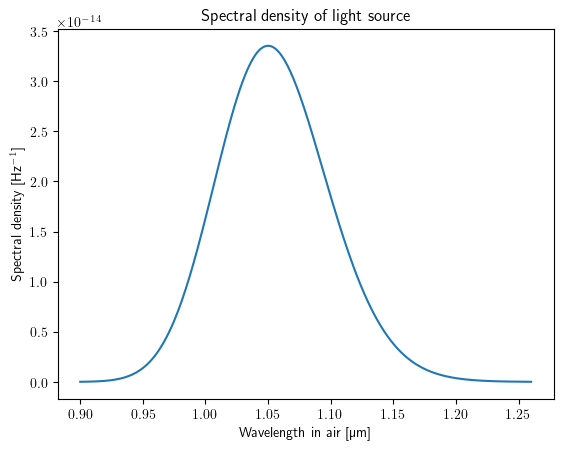

In [ ]:
# Spectral density
s_k = np.exp(- 8 * (kb - kbc) ** 2 / (Δkb ** 2))

if NORMALIZE:
    s_k /= (np.sum(s_k) * dνt)  # [Hz^-1]

plt.figure()
plt.plot(2 * np.pi / k, s_k)
plt.title("Spectral density of light source")
plt.xlabel("Wavelength in air [µm]")
plt.ylabel("Spectral density " + "[Hz$^{-1}$]" if NORMALIZE else "[a.u.]")
plt.show()

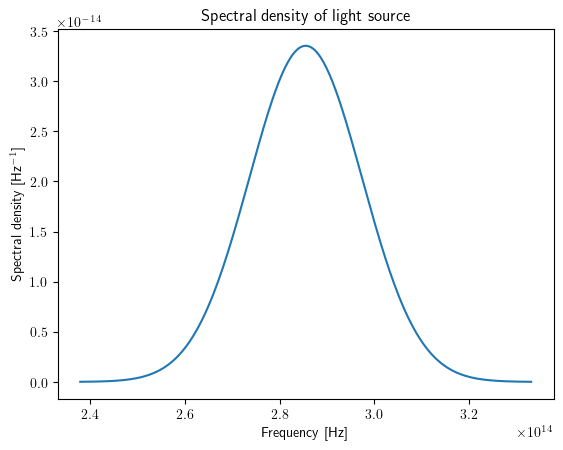

In [ ]:
plot_psfs_xl(psf_dict, TRANSPOSE=TRANSPOSE)

In [ ]:
plot_psfs_yl(psf_dict, TRANSPOSE=TRANSPOSE)

In [ ]:
for i in range(z.size):
    plot_psf_xl(psf_dict, i=i, show_FWHM=False, TRANSPOSE=TRANSPOSE, cbar_orientation='horizontal')

RMS wavefront error [µm]: 0.23478500803926985


In [ ]:
for i in range(z.size):
    plot_psf_yl(psf_dict, i=i, show_FWHM=False, TRANSPOSE=TRANSPOSE)

In [ ]:
for i in range(z.size):
    plot_psf_xy(psf_dict, i=i, num=None, l_i_s=0, show_FWHM=False)

In [ ]:
# Pupil coordinates
νpx_num = 257
# νpx_num = 501

if img_mode == IMG_MODE.SCFF:
    na_co_ill_max = 0.0
else:
    if np.isscalar(pupil_ill.na_co):
        na_co_ill_max = pupil_ill.na_co
    else:
        na_co_ill_max = max(pupil_ill.na_co)

if np.isscalar(pupil_col.na_co):
    na_co_col_max = pupil_col.na_co
else:
    na_co_col_max = max(pupil_col.na_co)

νx_max = (kb.max() / (2 * np.pi)) * max(na_co_ill_max, na_co_col_max)
νpx, νpy = np.meshgrid(
    np.linspace(start=-νx_max, stop=νx_max, num=νpx_num, dtype=np.float32),
    np.linspace(start=-νx_max, stop=νx_max, num=νpx_num, dtype=np.float32),
    indexing='xy'
)

dνx = dνy = νpx[0, 1] - νpx[0, 0]

In [ ]:
# Spatial frequency coordinates for the illumination pupil
match img_mode:
    case IMG_MODE.SCFF:
        νx_ill = None
        νy_ill = None
    case IMG_MODE.PSFD:
        νx_ill = νpx
        νy_ill = νpy
    case IMG_MODE.LF:
        νx_ill = νpx[None, 0]
        νy_ill = np.zeros_like(νx_ill)

In [ ]:
# Pupil coordinates for the central wavelength
if img_mode == IMG_MODE.SCFF:
    pass
else:
    σxc_ill = - 2 * np.pi * νx_ill / kbc
    σyc_ill = - 2 * np.pi * νy_ill / kbc
σxc_col = - 2 * np.pi * νpx / kbc
σyc_col = - 2 * np.pi * νpy / kbc

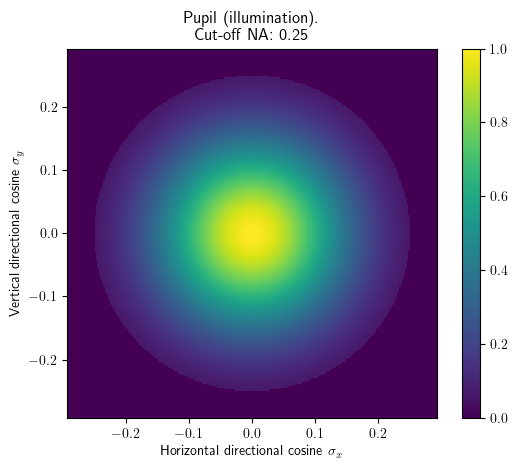

In [ ]:
# 2D plot of the illumination pupil
match img_mode:
    case IMG_MODE.SCFF:
        pass
    case IMG_MODE.LF:
        P = pupil_ill.pupil2D(σxc_ill, σyc_ill)
        plt.figure()
        plt.plot(σxc_ill[0], P[0])
        plt.title(
            "Pupil (illumination).\n"
            "Cut-off NA: {}".format(
                pupil_ill.na_co
            )
        )
        plt.xlabel(HORIZONTAL_COS_LABEL)
        plt.show()
    case IMG_MODE.PSFD:
        plot_2Dpupil(
            pupil_ill,
            σxc_ill,
            σyc_ill,
            'illumination'
        )

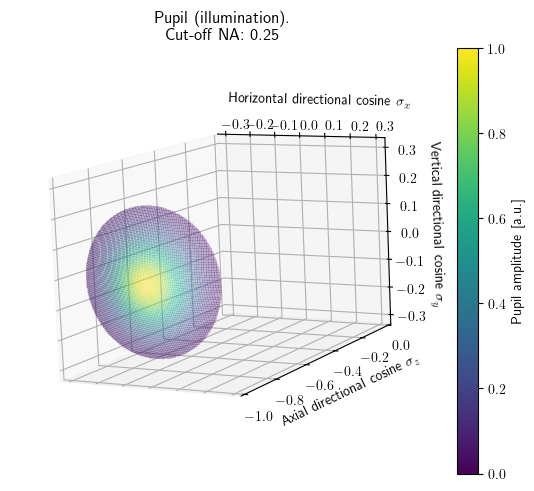

In [ ]:
# 3D surface plot of the illumination pupil
if img_mode == IMG_MODE.PSFD:
    plot_3Dpupil(
        pupil_ill,
        σxc_ill,
        σyc_ill,
        'illumination'
    )

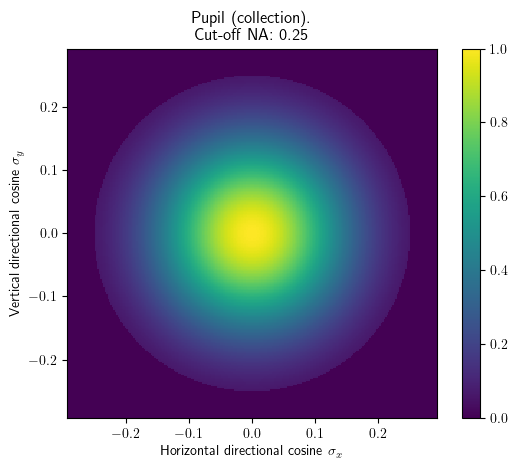

In [ ]:
# 2D plot of the collection pupil

plot_2Dpupil(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

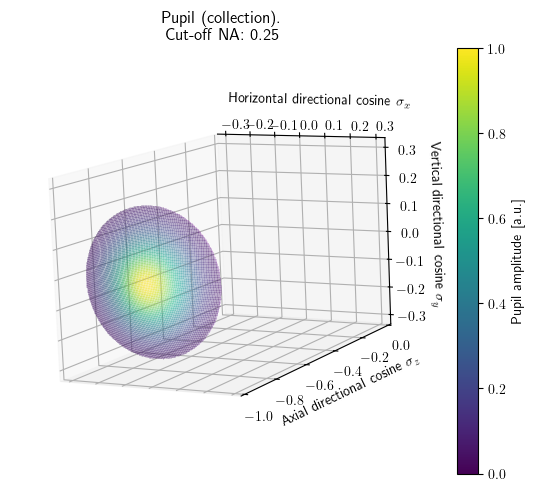

In [ ]:
# 3D surface plot of the collection pupil
plot_3Dpupil(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

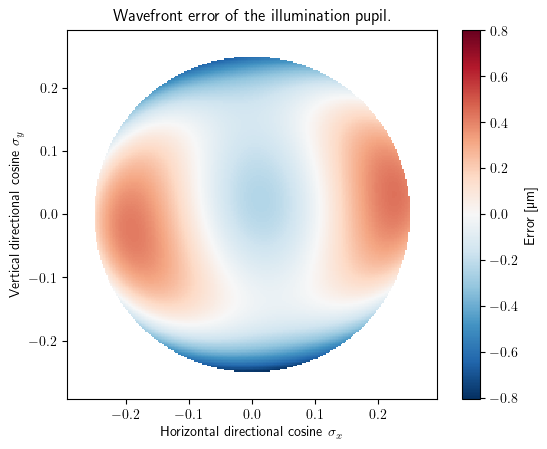

In [ ]:
# 2D plot of wavefront error in illumination pupil
match img_mode:
    case IMG_MODE.SCFF:
        pass
    case IMG_MODE.LF:
        pupil_ill.set_wavefront_error(σxc_ill, σyc_ill)
        W_ill = pupil_ill.we
        plt.figure()
        plt.plot(σxc_ill[0], W_ill[0])
        plt.title("Wavefront error of the illumination pupil.")
        plt.xlabel(HORIZONTAL_COS_LABEL)
        plt.show()
    case IMG_MODE.PSFD:
        plot_wavefronterror(
            pupil_ill,
            σxc_ill,
            σyc_ill,
            'illumination'
        )

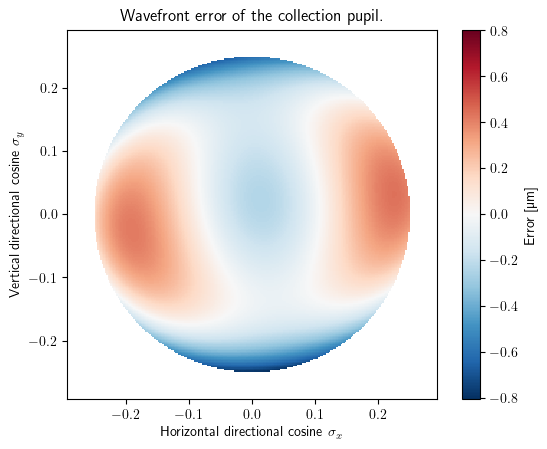

In [ ]:
# 2D plot of wavefront error in collection pupil
plot_wavefronterror(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

In [ ]:
# Spatial coordinate
match img_mode:
    case IMG_MODE.SCFF:
        νx_num = νpx_num
        νy_num = νpx_num
    case IMG_MODE.PSFD:
        νx_num = νpx_num * 2 - 1  # Doubled to take into account convolution
        νy_num = νpx_num * 2 - 1  # Doubled to take into account convolution
    case IMG_MODE.LF:
        νx_num = νpx_num * 2 - 1  # Doubled to take into account convolution
        νy_num = νpx_num
    case _:
        raise ValueError("Invalid imaging mode")
y = sp.fft.fftshift(sp.fft.fftfreq(νy_num, (νpy[1, 0] - νpy[0, 0])))
x = sp.fft.fftshift(sp.fft.fftfreq(νx_num, (νpx[0, 1] - νpx[0, 0])))

print(x.max() - x.min())

343.20963915806476


In [ ]:
# Spatial frequency coordinates for the aperture
νx = sp.fft.fftshift(sp.fft.fftfreq(νx_num, 1 / (νx_num * (νpx[0, 1] - νpx[0, 0]))))
νy = sp.fft.fftshift(sp.fft.fftfreq(νy_num, 1 / (νy_num * (νpy[1, 0] - νpy[0, 0]))))

ν_xx, ν_yy = np.meshgrid(
    νx, νy,
    indexing='xy'
)

In [ ]:
# Axial location
z0 = 0.0  # Axial position of the focal plane

# Scatterers' locations
zs = np.array([0., 100., 200., -100., -200.], dtype=np.float32)
z = z0 - zs
idx_zs0 = np.where(zs == 0)[0][0]
idx_z0 = np.where((z0 - zs) == 0)[0][0]

In [ ]:
# Initialize

h_tilde = np.zeros((νy_num, νx_num) + z.shape + k.shape, dtype=np.complex64)

ill_amp = np.zeros(k.shape, dtype=np.float32)
col_amp = np.zeros(k.shape, dtype=np.float32)

h_tilde.nbytes / 1024 ** 2

3021.7692947387695

In [ ]:
aperture = Aperture(pupil_ill, pupil_col, img_mode)

In [ ]:
for i, kb_i in enumerate(tqdm(kb)):

    h_tilde[..., i] = aperture(
        (νx_ill, νy_ill),
        (νpx, νpy),
        kb_i, z,
        NORMALIZE, idx_z0=idx_z0, PARAXIAL=PARAXIAL
    )

    if NORMALIZE:
        ill_amp[i] = aperture.ill_amp
        col_amp[i] = aperture.col_amp

  0%|          | 0/301 [00:00<?, ?it/s]

In [ ]:
# Apply phase shift of propagation to the focal plane
h_tilde = h_tilde * np.exp(1j * kb * 2 * z0)[None, None, None, :]

In [ ]:
# Center of gravity of the OCT's spectrum
k_cg = np.sum(s_k * (kb ** 2) * k) / np.sum(s_k * (kb ** 2))

In [ ]:
# Offset of the starting point of the spectrum fron the center of gravity
k_offset = k[0] - k_cg

In [ ]:
# complex point-spread function
# FFT k -> z

SF_MODE = 'PSF'
# SF_MODE = 'LSF'

x12 = [-40.0, 40.0]
xd_num = 129

lw = 20.0 * 2
ld_num = 65

psf = np.zeros((xd_num, xd_num, z.size, ld_num), dtype=np.complex64)
h_tilde_OCT = np.zeros((νy_num, νx_num, z.size, ld_num), dtype=np.complex64)
xd = np.linspace(x12[0], x12[1], num=xd_num, endpoint=True)
ld = np.zeros((ld_num, z.size), dtype=np.float32)  # single-trip OPL

for i in trange(z.size):
    l12 = [nb * zs[i] * 2 - lw / 2, nb * zs[i] * 2 + lw / 2]

    ld[..., i] = np.linspace(l12[0], l12[1], num=ld_num, endpoint=True) / 2

    h_tilde_OCT[..., i, :] = zoom_fft_correct_phase(
            (s_k * (kb ** 2) / (4 * np.pi))[None, None, :]
            * h_tilde[..., i, :],
            l12,
            k_offset / (2 * np.pi),
            fs=(2 * np.pi)/(k[1] - k[0]),
            m=ld_num,
            axis=-1
        ) * dνt

    if SF_MODE == 'PSF':
        psf[..., i, :] = zoom_fft_correct_phase(
            zoom_fft_correct_phase(
                h_tilde_OCT[..., i, :], x12, νx[0],
                fs=1/dνx, m=xd_num, axis=1
            ) * dνx,
            x12, νy[0],
            fs=1/dνy, m=xd_num, axis=0
        ) * dνy
    elif SF_MODE == 'LSF':
        # Layer-spread function
        # This corresponds to the common axial PSF measurements in OCT.
        # The sample is assumed to be a reflective plane, such as a mirror.
        psf[..., i, :] = zoom_fft_correct_phase(
            zoom_fft_correct_phase(
                h_tilde_OCT[νy_num // 2, νx_num // 2, None, None, i, :],
                x12, νx[0],
                fs=1/dνx, m=xd_num, axis=1
            ) * dνx,
            x12, νy[0],
            fs=1/dνy, m=xd_num, axis=0
        ) * dνy

psf_dict: PSFDict = {
    'psf': psf, 'x': xd, 'defocus': -z, 'opl': ld, 'nb': nb,
    'desc': 'Raw', 'MODE': img_mode, 'NORMALIZE': NORMALIZE
}

  0%|          | 0/5 [00:00<?, ?it/s]

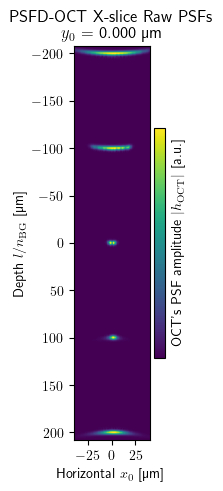

In [ ]:
plot_psfs_xl(psf_dict, TRANSPOSE=TRANSPOSE)

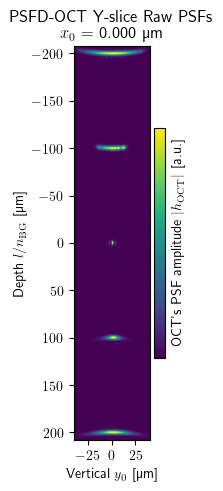

In [ ]:
plot_psfs_yl(psf_dict, TRANSPOSE=TRANSPOSE)

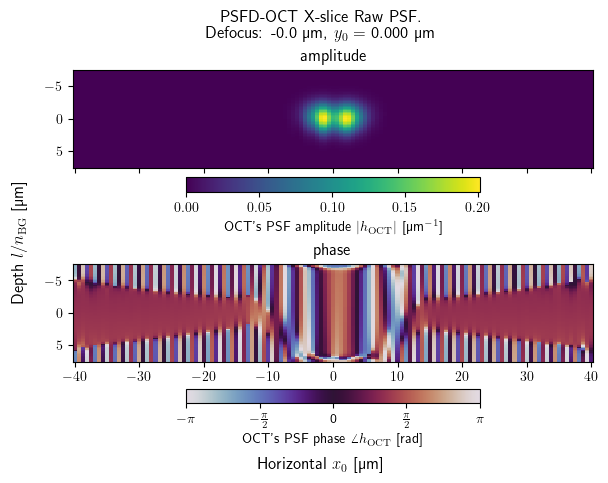

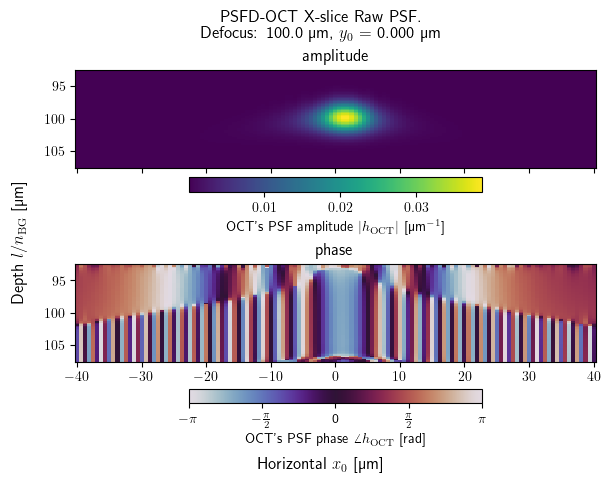

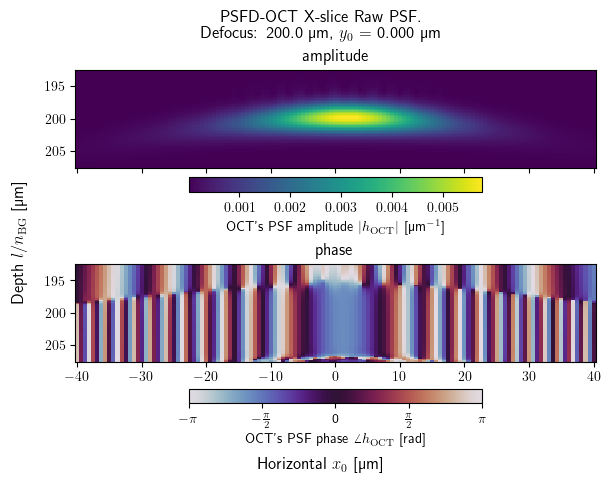

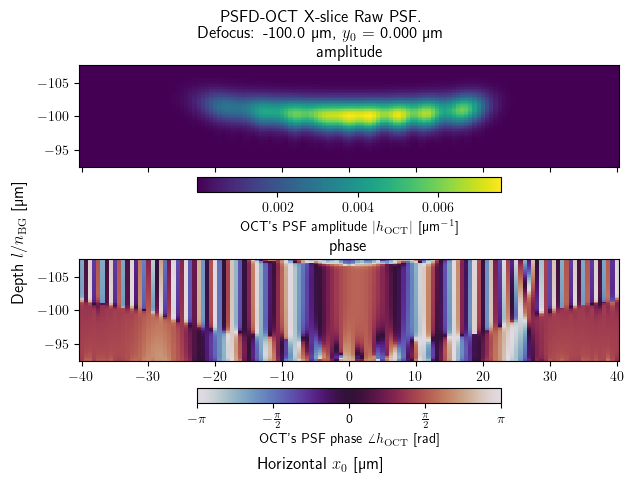

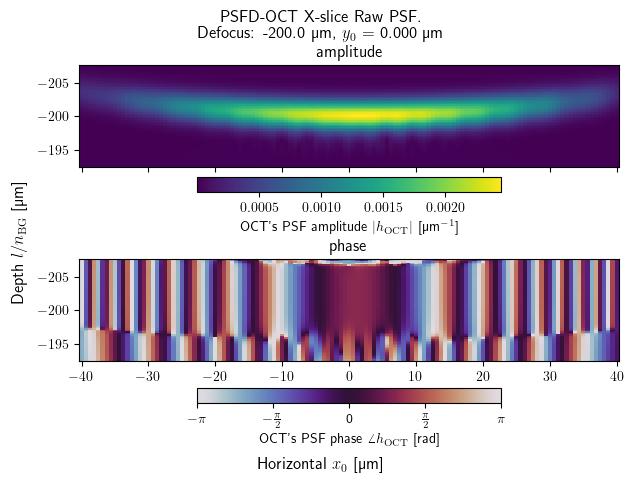

In [ ]:
for i in range(z.size):
    plot_psf_xl(psf_dict, i=i, show_FWHM=False, TRANSPOSE=TRANSPOSE, cbar_orientation='horizontal')

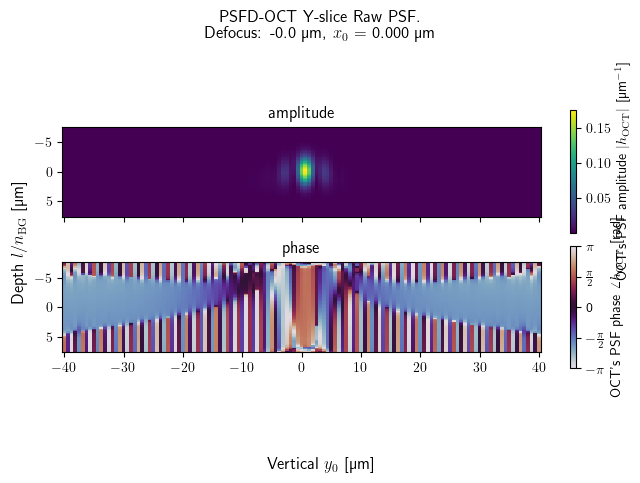

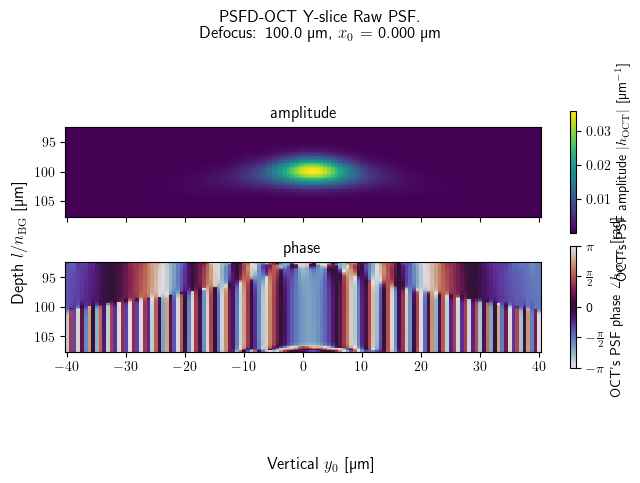

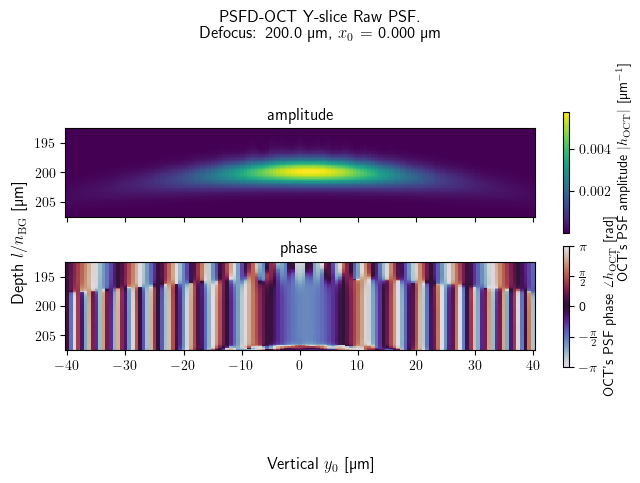

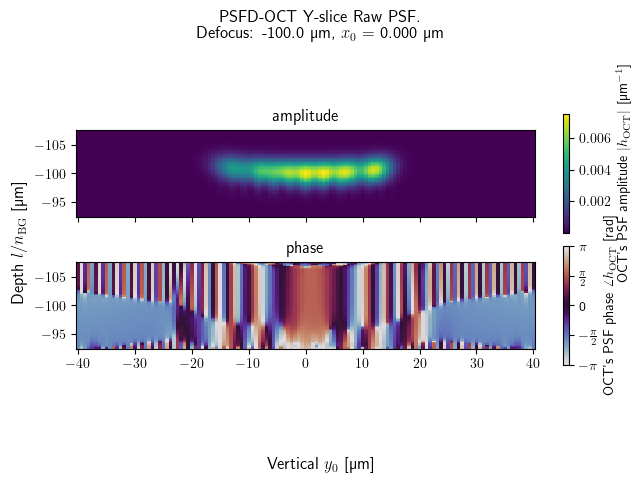

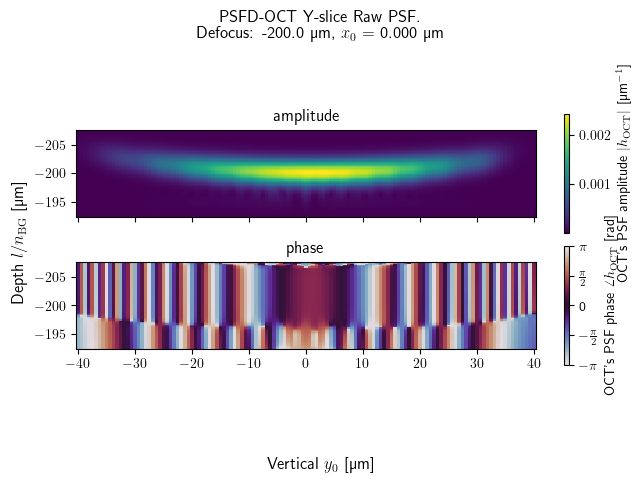

In [ ]:
for i in range(z.size):
    plot_psf_yl(psf_dict, i=i, show_FWHM=False, TRANSPOSE=TRANSPOSE)

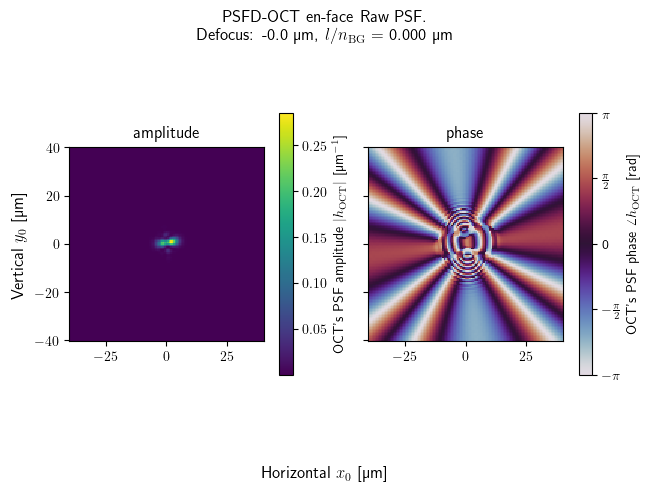

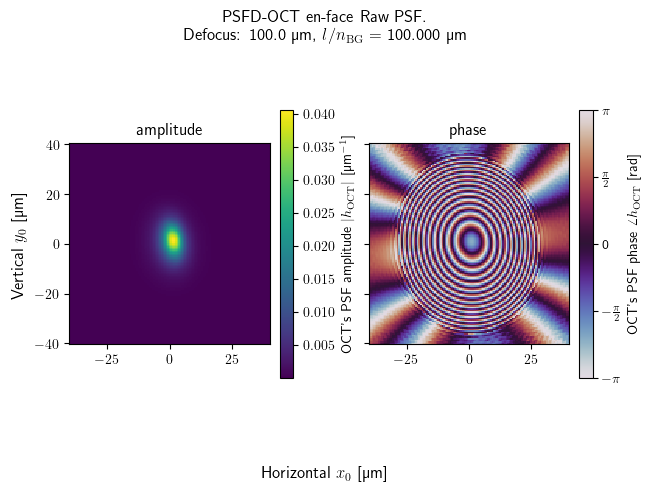

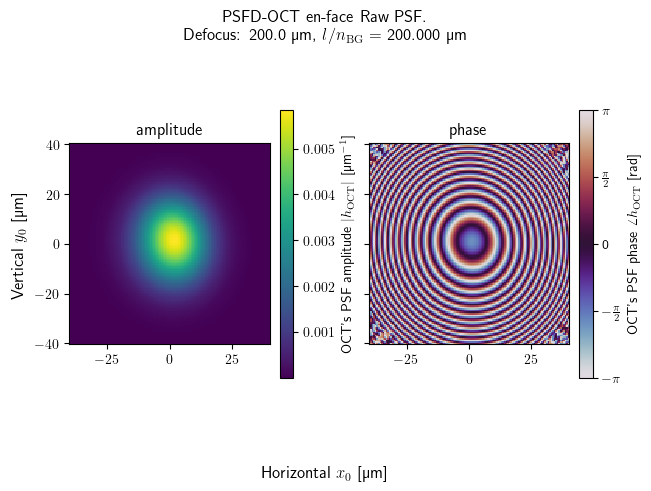

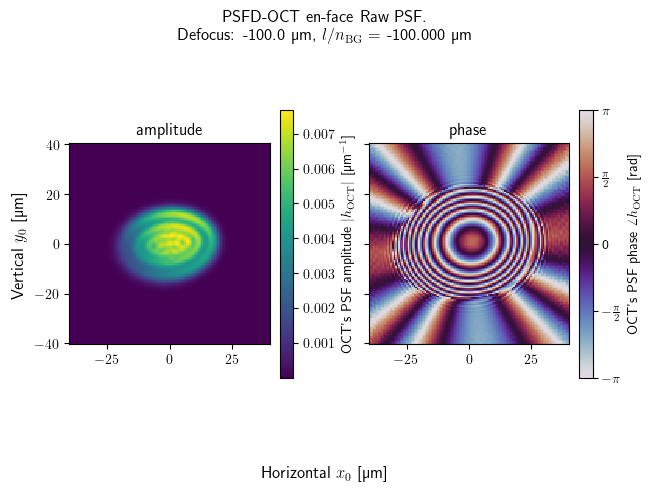

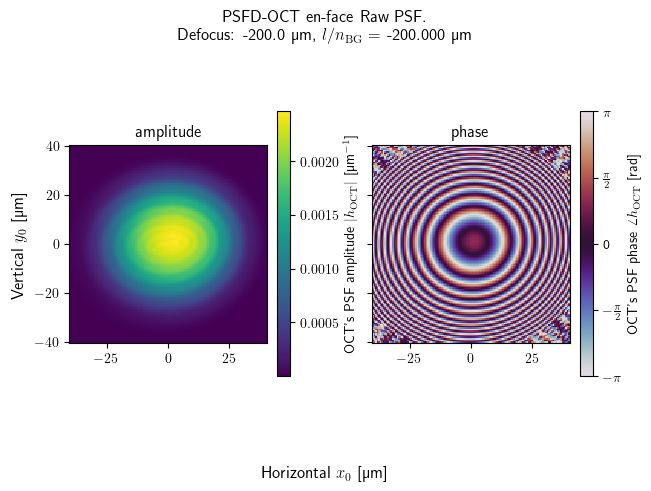

In [ ]:
for i in range(z.size):
    plot_psf_xy(psf_dict, i=i, num=None, l_i_s=0, show_FWHM=False)

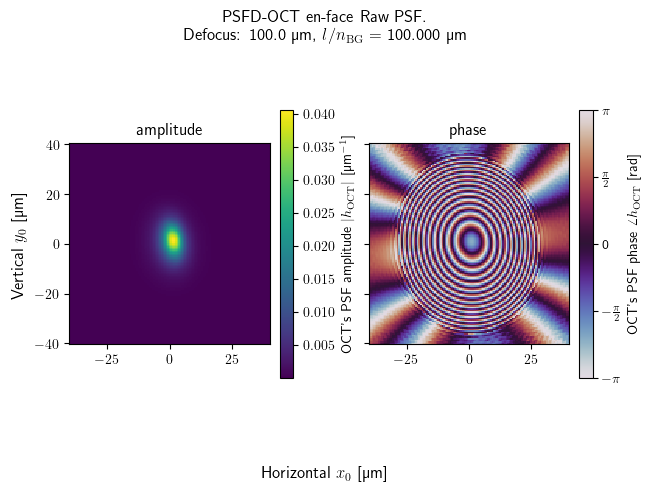

0.04056445

In [ ]:
plot_psf_xy(psf_dict, i=1, num=None, l_i_s=-0, show_FWHM=False)

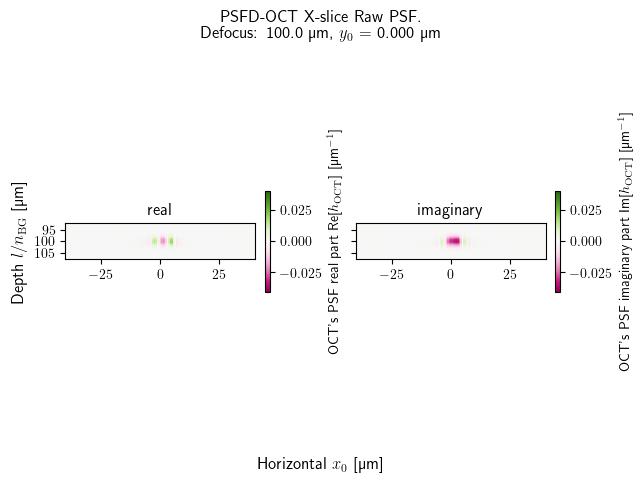

In [ ]:
plot_psf_xl_reim(psf_dict, i=1, TRANSPOSE=TRANSPOSE)

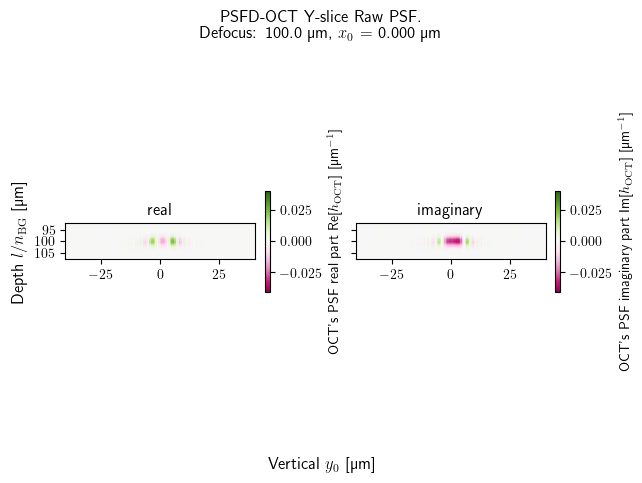

In [ ]:
plot_psf_yl_reim(psf_dict, i=1, TRANSPOSE=TRANSPOSE)

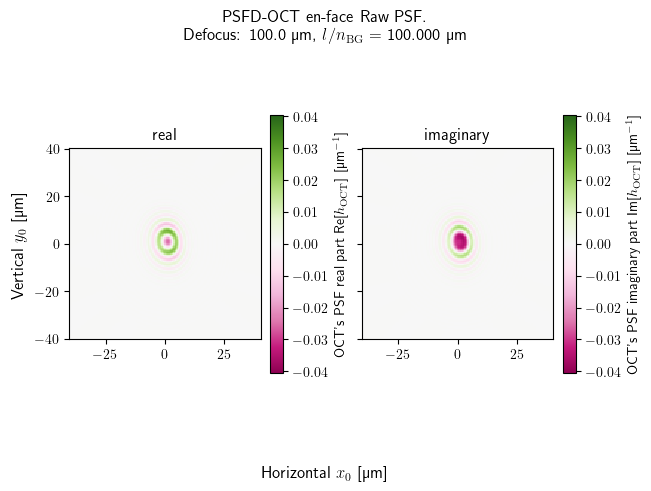

In [ ]:
plot_psf_xy_reim(psf_dict, i=1, num=None, l_i_s=-0)

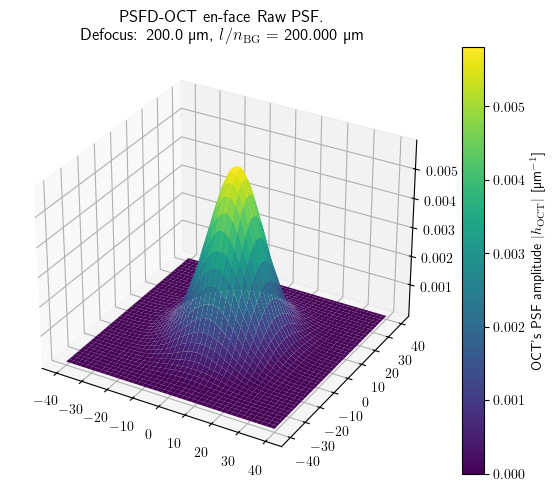

0.005842906

In [ ]:
plot_psf_xy_3d(psf_dict, i=2, num=None, l_i_s=0, show_FWHM=False, vmin=0.0)

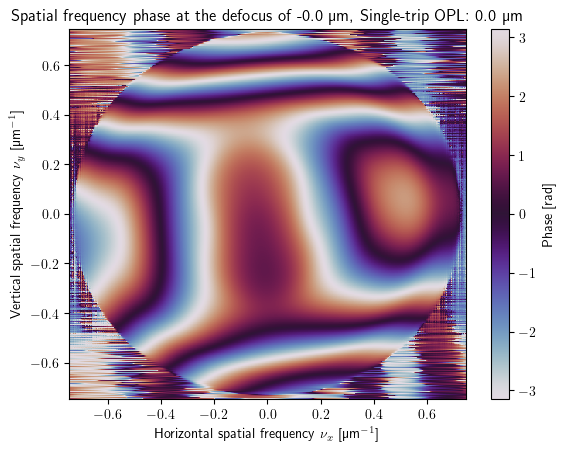

In [ ]:
idx_z0 = np.where(z == 0)[0][0]
idx_l0 = np.argmin(np.abs(ld[:, idx_z0] - nb * z0))
plt.figure()
plt.pcolormesh(
    νx, νy,
    np.angle(h_tilde_OCT[:, :, idx_z0, idx_l0]),
    vmin=-np.pi, vmax=np.pi,
    cmap="twilight",
)
plt.title("Spatial frequency phase at the defocus of {} µm, Single-trip OPL: {} µm".format(-z[idx_z0], ld[idx_l0, idx_z0]))
plt.xlabel(HORIZONTAL_FREQ_LABEL)
plt.ylabel(VERTICAL_FREQ_LABEL)
plt.colorbar(label='Phase [rad]')
plt.show()

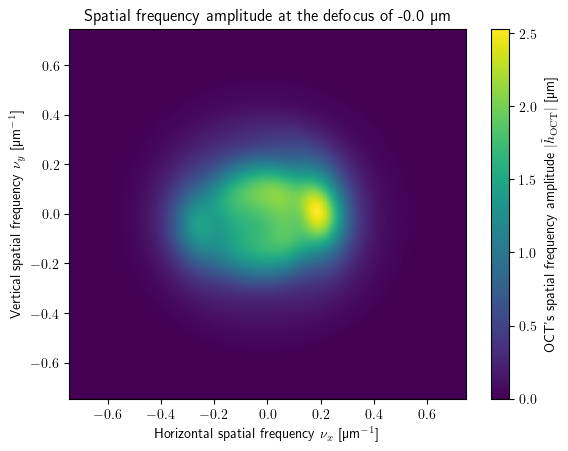

In [ ]:
plt.figure()
plt.pcolormesh(
    νx, νy,
    np.abs(h_tilde_OCT[:, :, idx_z0, idx_l0]),
)
plt.title("Spatial frequency amplitude at the defocus of {} µm".format(-z[idx_z0]))
plt.xlabel(HORIZONTAL_FREQ_LABEL)
plt.ylabel(VERTICAL_FREQ_LABEL)
plt.colorbar(label=OCT_SPECT_AMP_LABEL + oct_htilde_unit(NORMALIZE and img_mode == IMG_MODE.PSFD))
plt.show()